# Tập dữ liệu về xe

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# from Test.tmo import X_train

warnings.filterwarnings('ignore')

In [28]:
def analyze_dataframe(df):
    # 1. In ra số dòng, tên các cột của DataFrame
    print("THÔNG TIN CƠ BẢN VỀ TẬP DỮ LIỆU:")
    print("-" * 50)
    print(f"Số dòng: {df.shape[0]}")
    print(f"Số cột: {df.shape[1]}")
    print("\nTên các cột:")
    for col in df.columns:
        print(f"- {col}")

    # 2. In ra 5 dòng đầu tiên của tập dữ liệu
    print("\n5 DÒNG ĐẦU TIÊN CỦA TẬP DỮ LIỆU:")
    print("-" * 50)
    print(df.head())

    # 3. Hiển thị thông tin chi tiết hơn về dataframe
    print("\nTHÔNG TIN CHI TIẾT VỀ DATAFRAME:")
    print("-" * 50)
    df.info()  # info() đã tự in nên không cần print()

    # 4. Hiển thị thống kê mô tả
    print("\nTHỐNG KÊ MÔ TẢ:")
    print("-" * 50)
    print(df.describe())

    # 5. Kiểm tra giá trị null
    print("\nKIỂM TRA GIÁ TRỊ NULL:")
    print("-" * 50)
    null_counts = df.isnull().sum()
    null_columns = null_counts[null_counts > 0]
    print(null_columns)


In [29]:
df_train = pd.read_csv("Data/train.csv")

In [30]:
analyze_dataframe(df_train)

THÔNG TIN CƠ BẢN VỀ TẬP DỮ LIỆU:
--------------------------------------------------
Số dòng: 1647
Số cột: 20

Tên các cột:
- Make
- Model
- Price
- Year
- Kilometer
- Fuel Type
- Transmission
- Location
- Color
- Owner
- Seller Type
- Engine
- Max Power
- Max Torque
- Drivetrain
- Length
- Width
- Height
- Seating Capacity
- Fuel Tank Capacity

5 DÒNG ĐẦU TIÊN CỦA TẬP DỮ LIỆU:
--------------------------------------------------
            Make                            Model     Price  Year  Kilometer  \
0            BMW                    3-Series 320d    800000  2012      75576   
1            BMW               X1 sDrive20d xLine   2199000  2016      77000   
2       Mahindra                   XUV500 W4 1.99    800000  2017     112000   
3  Mercedes-Benz                  GLS 400d 4MATIC  12900000  2021       3000   
4         Toyota  Fortuner 2.8 4x2 AT [2016-2020]   3499000  2019      73000   

  Fuel Type Transmission     Location   Color   Owner Seller Type   Engine  \
0    Diese

# Tiền xử lý dữ liệu

# Xử lý giá trị thiếu và giá trị ngoại lai

Chúng em đã đóng gói quy trình xử lý ngoại lai vào trong một class `VehicleDataPreprocessor` dùng để xử lý dữ liệu dạng số và dạng phân loại trong dữ liệu gốc. Trong class này bọn em sử dụng những kỹ thuật:
- Điền missing values bằng median và mode.
- Biển đổi Logarithm.
- Kỹ thuật Winsorization.
- One-Hot Encoding
- Xử lý Multicolineatiry
- Group-Rare
- Smooth Target Encoding


Chúng em có viết lại class dưới đây (class gốc ở `PreProcessing/VehicleDataPreprocessor`)


In [31]:
# Import VehicleDataPreprocessor
# from PreProcessing.VehicleDataPreprocessor import VehicleDataPreprocessor

In [32]:
import pandas as pd
import numpy as np
import pickle

class VehicleDataPreprocessor:
    def __init__(self, make_encoder_path=None):
        # Tải Make encoder nếu được cung cấp
        self.make_encoder = None
        if make_encoder_path:
            try:
                with open(make_encoder_path, 'rb') as f:
                    self.make_encoder = pickle.load(f)
            except Exception as e:
                print(f"Cảnh báo: Không thể tải make encoder: {e}")

        # Giá trị toàn cục cho việc điền giá trị còn thiếu (quan trọng cho tập TEST)
        self.global_fill_na = {
            'Max_Power_Value': 117.0,
            'Max_Power_RPM': 4200.0,
            'Max_Torque_Value': 200.0,
            'Max_Torque_RPM': 1900.0,
            'Engine_Value': 1498.0,
            'Width': 1775.0,
            'Kilometer_Log': 10.819798284210286,
            'Length': 4370.0,
            'Height': 1550.0,
            'Fuel Tank Capacity': 50.0,
            'Make_encoded': 13.81,
            'Drivetrain_encoded': 13.81
        }

        self.normalization = {
            "Kilometer":(53191.1834138313, 32879.80430210077),
            "Length":(4284.273224043716, 441.3003313067076),
            "Width":(1764.5761991499696, 125.04245739945704),
            "Fuel Tank Capacity":(52.03691560412872, 14.98612512467079),
            "Engine_Value":(1680.7843222252202, 572.5427642880683),
            "Max_Power_Value":(129.1757408654926, 62.90556697702773),
            "Max_Power_RPM":(4802.425015179114, 1084.3978250935734),
            "Max_Torque_Value":(244.4114520340012, 138.516871636592),
            "Max_Torque_RPM":(2593.386763812993, 1185.6349424108332),
            "Make_encoded":(13.786248965490113, 0.7088298483961224),
            "Drivetrain_encoded": (13.80687969810898, 0.6183596634916549),
            "Year": (2016.4195506982392, 3.3703274633057414),
            "Log_Price": (13.80687969810898, 0.9834000219767532)
        }

        self.price_outlier_threshold = 15468306.941920616
        # self.price_outlier_threshold = 11220004.286635086


    def preprocess(self, df, train=False, norm=True):
        """Pipeline tiền xử lý chính gọi tất cả các phương thức tiền xử lý riêng lẻ"""
        df = df.copy()  # Không sửa đổi dataframe gốc

        # Xử lý từng cột
        # df = self._process_initial_stage(df)
        df = self._process_price(df, train=train)
        df = self._process_year(df)
        df = self._process_engine(df)
        df = self._process_max_power(df)
        df = self._process_max_torque(df)
        df = self._process_width(df)
        df = self._process_kilometer(df)
        df = self._process_make(df)
        df = self._process_drivetrain(df)
        df = self._process_fuel_type(df)
        df = self._process_transmission(df)
        df = self._process_color(df)
        df = self._process_owner(df)
        df = self._process_seller_type(df)
        df = self._process_seating_capacity(df)
        df = self._process_remaining_numeric_cols(df)
        df = self._process_final_stage(df)
        if norm: df = self._normalize_data(df)

        return df

    def _process_initial_stage(self, df):
        """Loại bỏ những cột không cần thiết"""
        df.drop(["Model", "Location"], axis=1, inplace=True)

        return df

    def _process_price(self, df, train):
        """Xử lý cột Price: chuyển đổi log và loại bỏ cột gốc"""
        if 'Price' in df.columns:
            df['Log_Price'] = np.log(df['Price'])
            if train:
                df = df[df["Price"] < self.price_outlier_threshold]
                # df = df[(df['Price'] > 12000000) | (df['Price'] < 11000000)]
            df.drop('Price', axis=1, inplace=True)
        return df

    def _process_year(self, df):
        """Xử lý cột Year"""
        return df

    def _process_engine(self, df):
        """Xử lý cột Engine: trích xuất giá trị số, xử lý giá trị thiếu và ngoại lai"""
        if 'Engine' in df.columns:
            # Trích xuất giá trị số từ Engine (loại bỏ 'cc')
            df['Engine_Value'] = pd.to_numeric(df['Engine'].str.replace('cc', ''), errors='coerce')

            # CHÚ Ý: Điền giá trị NA cho tập TEST với giá trị 1498.0
            df['Engine_Value'].fillna(self.global_fill_na['Engine_Value'], inplace=True)

            # Xử lý ngoại lai bằng chuyển đổi log
            df['Engine_Value_Log'] = np.log(df['Engine_Value'])

            # Định nghĩa giới hạn cho xử lý ngoại lai (sử dụng các giá trị cố định)
            lower_bound = 6.83  # Sử dụng giá trị cố định từ hướng dẫn
            upper_bound = 8.06  # Sử dụng giá trị cố định từ hướng dẫn

            # Clip giá trị để xử lý ngoại lai
            df['Engine_Value_Log'] = df['Engine_Value_Log'].clip(lower=lower_bound, upper=upper_bound)

            # Chuyển đổi trở lại thang đo ban đầu
            df['Engine_Value'] = np.exp(df['Engine_Value_Log'])

            # Loại bỏ cột trung gian và cột gốc
            df.drop(['Engine_Value_Log', 'Engine'], axis=1, inplace=True)

        return df

    def _process_max_power(self, df):
        """Xử lý cột Max Power: tách thành giá trị và RPM, xử lý giá trị thiếu và ngoại lai"""
        if 'Max Power' in df.columns:
            # Tách Max Power thành giá trị và RPM
            df[['Max_Power_Value', 'Max_Power_RPM']] = df['Max Power'].str.split('@', expand=True)

            # Làm sạch giá trị RPM
            df['Max_Power_RPM'] = df['Max_Power_RPM'].str.strip().str.replace('rpm', '', regex=False)

            # Làm sạch giá trị Value (chỉ giữ số và dấu thập phân)
            df['Max_Power_Value'] = df['Max_Power_Value'].str.replace(r'[^\d.]+', '', regex=True)

            # Chuyển đổi sang dạng số, xử lý lỗi
            df['Max_Power_RPM'] = pd.to_numeric(df['Max_Power_RPM'], errors='coerce')
            df['Max_Power_Value'] = pd.to_numeric(df['Max_Power_Value'], errors='coerce')

            # CHÚ Ý: Điền giá trị NA cho tập TEST
            # Fill Max_Power_Value = 117.0 nếu nan
            # Fill Max_Power_RPM = 4200
            df['Max_Power_Value'].fillna(self.global_fill_na['Max_Power_Value'], inplace=True)
            df['Max_Power_RPM'].fillna(self.global_fill_na['Max_Power_RPM'], inplace=True)

            # Xử lý ngoại lai cho Max_Power_Value
            df['Max_Power_Value_Log'] = np.log(df['Max_Power_Value'])

            # Sử dụng giá trị cố định từ hướng dẫn gốc để đảm bảo nhất quán train-test
            lower_bound = 3.35
            upper_bound = 6.20

            df['Max_Power_Value_Log'] = df['Max_Power_Value_Log'].clip(lower=lower_bound, upper=upper_bound)
            df['Max_Power_Value'] = np.exp(df['Max_Power_Value_Log'])

            # Loại bỏ cột trung gian và cột gốc
            df.drop(['Max_Power_Value_Log', 'Max Power'], axis=1, inplace=True)

        return df

    def _process_max_torque(self, df):
        """Xử lý cột Max Torque: tách thành giá trị và RPM, xử lý giá trị thiếu và ngoại lai"""
        if 'Max Torque' in df.columns:
            # Tách Max Torque thành giá trị và RPM
            df[['Max_Torque_Value', 'Max_Torque_RPM']] = df['Max Torque'].str.split('@', expand=True)

            # Làm sạch giá trị RPM
            df['Max_Torque_RPM'] = df['Max_Torque_RPM'].str.strip().str.replace('rpm', '', regex=False)

            # Làm sạch giá trị Value (chỉ giữ số và dấu thập phân)
            df['Max_Torque_Value'] = df['Max_Torque_Value'].str.replace(r'[^\d.]+', '', regex=True)

            # Chuyển đổi sang dạng số, xử lý lỗi
            df['Max_Torque_RPM'] = pd.to_numeric(df['Max_Torque_RPM'], errors='coerce')
            df['Max_Torque_Value'] = pd.to_numeric(df['Max_Torque_Value'], errors='coerce')

            # CHÚ Ý: Điền giá trị NA cho tập TEST
            # Fill Max_Torque_Value = 200.0
            # Fill Max_Torque_RPM = 1900.0
            df['Max_Torque_Value'].fillna(self.global_fill_na['Max_Torque_Value'], inplace=True)
            df['Max_Torque_RPM'].fillna(self.global_fill_na['Max_Torque_RPM'], inplace=True)

            # Xử lý ngoại lai cho Max_Torque_Value
            # Sử dụng giá trị cố định từ hướng dẫn gốc
            lower_bound = -227.00
            upper_bound = 685.00

            df['Max_Torque_Value'] = df['Max_Torque_Value'].clip(lower=max(0, lower_bound), upper=upper_bound)

            # Loại bỏ cột gốc
            df.drop('Max Torque', axis=1, inplace=True)

        return df

    def _process_width(self, df):
        """Xử lý cột Width: xử lý giá trị thiếu và ngoại lai"""
        if 'Width' in df.columns:
            # CHÚ Ý: Điền giá trị NA cho tập TEST = 1775.0
            df['Width'].fillna(self.global_fill_na['Width'], inplace=True)

            # Xử lý ngoại lai với các giá trị được chỉ định cố định
            lower_bound = 1491.00
            upper_bound = 2035.00

            df['Width'] = df['Width'].clip(lower=lower_bound, upper=upper_bound)

        return df

    def _process_kilometer(self, df):
        """Xử lý cột Kilometer: chuyển đổi log và xử lý ngoại lai"""
        if 'Kilometer' in df.columns:
            # Chuyển đổi log (log1p = log(1+x))
            df['Kilometer_Log'] = np.log1p(df['Kilometer'])

            # CHÚ Ý: Điền giá trị NA cho tập TEST = 10.819798284210286
            df['Kilometer_Log'].fillna(self.global_fill_na['Kilometer_Log'], inplace=True)

            # Xử lý ngoại lai với các giá trị đã được chỉ định cố định
            lower_bound = 8.91
            upper_bound = 12.55

            df['Kilometer_Log'] = df['Kilometer_Log'].clip(lower=lower_bound, upper=upper_bound)

            # Chuyển đổi trở lại thang đo ban đầu
            df['Kilometer'] = np.expm1(df['Kilometer_Log'])

            # Loại bỏ cột trung gian
            df.drop('Kilometer_Log', axis=1, inplace=True)

        return df

    def _process_remaining_numeric_cols(self, df):
        """Xử lý các cột số còn lại: Length, Height, Fuel Tank Capacity"""
        # CHÚ Ý: Điền giá trị NA cho tập TEST với các giá trị cố định
        # Fill 'Length' = 4370.00
        # Fill 'Height' = 1550.00
        # Fill 'Fuel Tank Capacity' = 50.00
        numeric_cols = ['Length', 'Height', 'Fuel Tank Capacity']

        for col in numeric_cols:
            if col in df.columns:
                df[col].fillna(self.global_fill_na[col], inplace=True)

        return df

    def _process_make(self, df):
        """Xử lý cột Make: áp dụng mã hóa target"""
        if 'Make' in df.columns:
            # Nếu không có encoder từ file pkl, sử dụng dictionary
            if self.make_encoder is None:
                self.make_encoder = {
                    'Maruti Suzuki': 13.0876568212651,
                    'Hyundai': 13.332835658211609,
                    'Mercedes-Benz': 14.979287245081439,
                    'Honda': 13.247622182348156,
                    'Toyota': 14.103649799670542,
                    'Audi': 14.645617786857711,
                    'Mahindra': 13.7548285741869,
                    'BMW': 14.970197610360676,
                    'Tata': 13.539726337744348,
                    'Ford': 13.701192212433263,
                    'Renault': 13.085894547754995,
                    'Volkswagen': 13.36190214923346,
                    'Skoda': 13.940173966008981,
                    'Land Rover': 15.278102064185989,
                    'Jaguar': 14.766056716400424,
                    'Jeep': 14.252383454646322,
                    'Volvo': 14.426292544644863,
                    'Kia': 14.082939331174831,
                    'MG': 14.235879202727373,
                    'Nissan': 13.343536423603807,
                    'MINI': 14.516270808655126,
                    'Porsche': 15.073386981633433,
                    'Datsun': 13.076001247571691,
                    'Chevrolet': 13.244374287794319,
                    'Lexus': 14.414617681160243,
                    'Ssangyong': 13.744651156585752,
                    'Mitsubishi': 13.977824558629855,
                    'Rolls-Royce': 14.920345808680235,
                    'Fiat': 13.462345798374823,
                    'Lamborghini': 14.337993813142857,
                    'Isuzu': 13.905447195264628
                }

            # Tạo cột mã hóa
            df['Make_encoded'] = df['Make'].map(self.make_encoder)

            # CHÚ Ý: Điền giá trị NA cho tập TEST = 13.81 (Global_mean)
            df['Make_encoded'].fillna(self.global_fill_na['Make_encoded'], inplace=True)

            # Loại bỏ cột gốc
            df.drop('Make', axis=1, inplace=True)

        return df

    def _process_drivetrain(self, df):
        """Xử lý cột Drivetrain: Target Encoding"""
        if 'Drivetrain' in df.columns:
            if self.make_encoder is None:
                self.make_encoder = {
                    'FWD': 13.420026478630321,
                    'RWD': 14.576673709596076,
                    'AWD': 14.982593641119296
                }

            df['Drivetrain_encoded'] = df['Drivetrain'].map(self.make_encoder)
            df['Drivetrain_encoded'].fillna(self.global_fill_na['Drivetrain_encoded'], inplace=True)
            df.drop('Drivetrain', axis=1, inplace=True)

        return df

    def _process_fuel_type(self, df):
        """Xử lý cột Fuel Type: nhóm các danh mục và mã hóa one-hot"""
        if 'Fuel Type' in df.columns:
            # CHÚ Ý: Điền giá trị NA cho tập TEST = "Diesel"
            df['Fuel Type'].fillna('Diesel', inplace=True)

            # Nhóm loại nhiên liệu sử dụng hàm
            def group_fuel_types(fuel_type):
                if fuel_type in ['Diesel']:
                    return 'Diesel'
                elif fuel_type in ['Petrol']:
                    return 'Petrol'
                elif fuel_type in ['CNG', 'CNG + CNG']:
                    return 'CNG'
                else:
                    return 'Others'  # Electric, Hybrid, LPG, Petrol + LPG

            df['Fuel_Type_Grouped'] = df['Fuel Type'].apply(group_fuel_types)

            # Mã hóa one-hot
            fuel_type_dummies = pd.get_dummies(df['Fuel_Type_Grouped'], prefix='Fuel')
            df = pd.concat([df, fuel_type_dummies], axis=1)

            # Loại bỏ các cột gốc và nhóm
            if 'Fuel_Diesel' in df.columns:
                df.drop(['Fuel Type', 'Fuel_Type_Grouped',
                         # 'Fuel_Diesel'
                         ], axis=1, inplace=True)
            else:
                df.drop(['Fuel Type', 'Fuel_Type_Grouped'], axis=1, inplace=True)

        return df

    def _process_transmission(self, df):
        """Xử lý cột Transmission: chuyển đổi thành tính năng nhị phân"""
        if 'Transmission' in df.columns:
            # CHÚ Ý: Điền giá trị NA cho tập TEST = "Manual"
            df['Transmission'].fillna('Manual', inplace=True)

            # Chuyển đổi thành tính năng nhị phân
            df['Transmission_is_Automatic'] = df['Transmission'].apply(lambda x: 1 if x == 'Automatic' else 0)

            # Loại bỏ cột gốc
            df.drop('Transmission', axis=1, inplace=True)

        return df

    def _process_color(self, df):
        """Xử lý cột Color: nhóm màu sắc và mã hóa one-hot"""
        if 'Color' in df.columns:
            # CHÚ Ý: Điền giá trị NA cho tập TEST = "White"
            df['Color'].fillna('White', inplace=True)

            # Sử dụng hàm nhóm màu sắc
            def group_colors(color):
                # Premium Colors: Blue, Black (giá cao, tần suất cao)
                if color in ['Blue', 'Black']:
                    return 'Premium'
                # White: giữ riêng vì là màu phổ biến nhất
                elif color == 'White':
                    return 'White'
                # Standard Colors: Grey, Red (giá trung bình, tần suất cao)
                elif color in ['Grey', 'Red']:
                    return 'Standard'
                # Silver: giữ riêng vì có tần suất cao nhưng giá thấp
                elif color == 'Silver':
                    return 'Silver'
                # Medium Colors: Brown, Maroon, Bronze, Gold, Green (tần suất trung bình)
                elif color in ['Brown', 'Maroon', 'Bronze', 'Gold', 'Green']:
                    return 'Medium'
                # Rare Colors: Beige, Yellow, Orange, Purple, Pink, Others (tần suất thấp)
                else:
                    return 'Rare'

            # Áp dụng hàm nhóm
            df['Color_Group'] = df['Color'].apply(group_colors)

            # Mã hóa one-hot
            color_group_dummies = pd.get_dummies(df['Color_Group'], prefix='Color')
            df = pd.concat([df, color_group_dummies], axis=1)

            # Loại bỏ cột gốc, nhóm và một danh mục tham chiếu
            if 'Color_White' in df.columns:
                df.drop(['Color', 'Color_Group',
                         # 'Color_White'
                         ], axis=1, inplace=True)
            else:
                df.drop(['Color', 'Color_Group'], axis=1, inplace=True)

        return df

    def _process_owner(self, df):
        """Xử lý cột Owner: nhóm chủ sở hữu và mã hóa one-hot"""
        if 'Owner' in df.columns:
            # CHÚ Ý: Điền giá trị NA cho tập TEST = "First"
            df['Owner'].fillna('First', inplace=True)

            # Sử dụng hàm phân nhóm chủ sở hữu
            def group_owners(owner):
                if owner == 'UnRegistered Car':
                    return 'New'
                elif owner == 'First':
                    return 'First_Owner'
                elif owner == 'Second':
                    return 'Second_Owner'
                elif owner == 'Third':
                    return 'Third_Owner'
                else:  # Fourth, 4 or More
                    return 'Fourth_Plus_Owner'

            # Áp dụng hàm phân nhóm
            df['Owner_Group'] = df['Owner'].apply(group_owners)

            # Mã hóa one-hot
            owner_group_dummies = pd.get_dummies(df['Owner_Group'], prefix='Owner')
            df = pd.concat([df, owner_group_dummies], axis=1)

            # Loại bỏ cột gốc và nhóm
            df.drop(['Owner', 'Owner_Group'], axis=1, inplace=True)

        return df

    def _process_seller_type(self, df):
        """Xử lý cột Seller Type: mã hóa one-hot"""
        if 'Seller Type' in df.columns:
            # CHÚ Ý: Điền giá trị NA cho tập TEST = "Individual"
            df['Seller Type'].fillna('Individual', inplace=True)

            # Mã hóa one-hot
            seller_type_dummies = pd.get_dummies(df['Seller Type'], prefix='Seller')
            df = pd.concat([df, seller_type_dummies], axis=1)

            # Loại bỏ cột gốc và danh mục tham chiếu
            if 'Seller_Individual' in df.columns:
                df.drop(['Seller Type', 'Seller_Individual'], axis=1, inplace=True)
            else:
                df.drop(['Seller Type'], axis=1, inplace=True)

        return df

    def _process_seating_capacity(self, df):
        """Xử lý cột Seating Capacity: xử lý giá trị thiếu và mã hóa one-hot"""
        if 'Seating Capacity' in df.columns:
            # CHÚ Ý: Điền giá trị NA cho tập TEST = 5
            df['Seating Capacity'].fillna(5, inplace=True)

            # Chuyển đổi thành số nguyên
            df['Seating Capacity'] = df['Seating Capacity'].astype(int)

            # Mã hóa one-hot
            seating_capacity_dummies = pd.get_dummies(df['Seating Capacity'], prefix='Seating')
            df = pd.concat([df, seating_capacity_dummies], axis=1)

            # Loại bỏ cột gốc và danh mục tham chiếu
            if 'Seating_5' in df.columns:
                df.drop(['Seating Capacity', 'Seating_5'], axis=1, inplace=True)
            else:
                df.drop(['Seating Capacity'], axis=1, inplace=True)

        return df

    def _process_final_stage(self, df):
        """Chuyển boolean thành các giá trị 0, 1"""
        for col in df.columns:
            if df[col].dtype == 'bool':
                df[col] = df[col].astype(int)
        return df

    def _normalize_data(self, df):
        """Normalize data thành N(0,1)"""
        for col, (mean, std) in self.normalization.items():
            df[col] = (df[col] - mean) / std
        return df


In [33]:
processor = VehicleDataPreprocessor()
df_processed = processor.preprocess(df_train, train=True, norm=False)

Các thông tin cơ bản về dữ liệu sau khi được xử lý

In [34]:
analyze_dataframe(df_processed)

THÔNG TIN CƠ BẢN VỀ TẬP DỮ LIỆU:
--------------------------------------------------
Số dòng: 1637
Số cột: 39

Tên các cột:
- Model
- Year
- Kilometer
- Location
- Length
- Width
- Height
- Fuel Tank Capacity
- Log_Price
- Engine_Value
- Max_Power_Value
- Max_Power_RPM
- Max_Torque_Value
- Max_Torque_RPM
- Make_encoded
- Drivetrain_encoded
- Fuel_CNG
- Fuel_Diesel
- Fuel_Others
- Fuel_Petrol
- Transmission_is_Automatic
- Color_Medium
- Color_Premium
- Color_Rare
- Color_Silver
- Color_Standard
- Color_White
- Owner_First_Owner
- Owner_Fourth_Plus_Owner
- Owner_New
- Owner_Second_Owner
- Owner_Third_Owner
- Seller_Commercial Registration
- Seller_Corporate
- Seating_2
- Seating_4
- Seating_6
- Seating_7
- Seating_8

5 DÒNG ĐẦU TIÊN CỦA TẬP DỮ LIỆU:
--------------------------------------------------
                             Model  Year      Kilometer     Location  Length  \
0                    3-Series 320d  2012   75576.000000       Mumbai  4370.0   
1               X1 sDrive20d xLi

## Tạo đặc trung mới

Ở phần này chúng em đóng gói thành một class `FeatureSelector` đảm nhiệm hai nhiệm vụ:
- Tạo các đặc trưng phi tuyến mới
- Lựa chọn đặc trưng ứng với chỉ số của mô hình

Class gốc nằm ở `Preprocessing/FeatureSelector`

In [35]:
# from PreProcessing.FeatureSelector import FeatureSelector

import numpy as np
import pandas as pd

class FeatureSelector(object):
    features = {
        1: [
            'Length',
            'Fuel Tank Capacity',
            'Max_Power_Value',
            'Max_Torque_Value',
            'Make_encoded',
            'Fuel_Petrol',
            'Transmission_is_Automatic',
            'Owner_Third_Owner',
            'Seating_2',
            'Volume',
            'Log_Max_Power_Value',
            'Power_Density',
            'Length_Width_interaction',

            'Age',
            'Age_Length',
            'Age_Volume',
            'Age_Log_Kilometer',
            'Make_encoded_log',
        ],
        2: [
            'Kilometer',

            'Length',
            'Width',
            'Height',

            'Fuel Tank Capacity',
            'Engine_Value',
            'Max_Power_Value',
            'Max_Power_RPM',
            'Max_Torque_Value',
            'Max_Torque_RPM',

            'Make_encoded',

            'Fuel_Diesel',
            'Fuel_Petrol',

            'Transmission_is_Automatic',

            'Owner_Fourth_Plus_Owner',
            'Owner_New',

            'Seating_2',
            'Seating_4',

            'Volume',

            'Power_to_Weight',

            'Log_Kilometer',
            'Log_Max_Power_Value',
            'Log_Max_Torque_Value',

            'Power_Density',
            'Torque_Density',

            'Power_Torque_Ratio',

            'Length_Width_interaction',

            'Year_Inverse',
            'Age',
            'Age_squared',
            'Log_Age',
            'Age_Length',
            'Age_Height',
            'Age_Volume',
            'Age_Log_Kilometer',

            'Kilometer_per_Year',
            'Log_Kilometer_Length',
            'Log_Kilometer_Power',
            'Log_Kilometer_Torque',

            'Make_encoded_sqrt',
            'Make_encoded_log',
            'Make_encoded_squared',

            'Power_to_CC',
            'Torque_to_CC',
            'Power_to_Torque',
            'RPM_Ratio',
        ],
        3: [
            'Age',
            'Log_Max_Power_Value',
            'Age_Log_Kilometer',
            'Make_encoded',
            'Fuel Tank Capacity',
            'Fuel_Petrol',
            'Transmission_is_Automatic',
            'Owner_Fourth_Plus_Owner',
            'Seating_2',
            'Seating_4',
            'Length',
        ],
        4: [
            'Age',
            'Age_Length',
            'Age_Volume',
            'Age_Log_Kilometer',
            'Make_encoded',

            'Fuel Tank Capacity',

            'Length',
            'Width',
            'Length_Width_interaction',

            'Power_Density',

            'Color_Silver',

            'Seating_2',
            'Seating_4',
        ]
    }
    def __init__(self):
        pass

    @classmethod
    def _non_linearize_features(cls, df):
        df["Volume"] = df["Height"] * df["Width"] * df["Length"]
        df['Power_to_Weight'] = df['Max_Power_Value'] / df['Volume']
        df['Efficiency'] = df['Max_Power_Value'] / df['Fuel Tank Capacity']
        df['Log_Kilometer'] = np.log(df['Kilometer'])
        df['Log_Max_Power_Value'] = np.log(df['Max_Power_Value'])
        df['Log_Max_Torque_Value'] = np.log(df['Max_Torque_Value'])

        # Tương tác RPM
        df['Power_Density'] = df['Max_Power_Value'] / df['Max_Power_RPM']
        df['Torque_Density'] = df['Max_Torque_Value'] / df['Max_Torque_RPM']

        # Tỷ lệ Power/Torque
        df['Power_Torque_Ratio'] = df['Max_Power_Value'] / df['Max_Torque_Value']
        df['Length_Width_interaction'] = df['Length'] * df['Width']

        # Tương tác Year
        df['Sin_Year'] = np.sin(df['Year'])
        df['Year_Inverse'] = 1 / df['Year']
        df['Age'] = 2025 - df['Year']
        df['Age_squared'] = df['Age'] * df['Age']
        df['Log_Age'] = np.log(df['Age'])
        df['Sin_Age'] = np.sin(df['Age'])
        df['Age_Length'] = df['Age'] * df['Length']
        df['Age_Height'] = df['Age'] * df['Height']
        df['Age_Volume'] = df['Age'] * df['Volume']
        df['Age_Kilometer'] = df['Age'] * df['Kilometer']
        df['Age_Log_Kilometer'] = df['Age'] * df['Log_Kilometer']
        df['Kilometer_per_Year'] = df['Kilometer'] / df['Age'].clip(lower=1)
        df['Log_Kilometer_Length'] = df['Log_Kilometer'] * df['Length']
        df['Log_Kilometer_Power'] = df['Log_Kilometer'] * df['Max_Power_Value']
        df['Log_Kilometer_Torque'] = df['Log_Kilometer'] * df['Max_Torque_Value']

        df['Make_encoded_sqrt'] = np.sqrt(df['Make_encoded'])
        df['Make_encoded_log'] = np.log(df['Make_encoded'])
        df['Make_encoded_squared'] = df['Make_encoded'] ** 2

        df['Power_to_Weight'] = df['Max_Power_Value'] / df['Volume'].clip(lower=1)
        df['Power_to_CC'] = df['Max_Power_Value'] / df['Engine_Value'].clip(lower=1)
        df['Torque_to_CC'] = df['Max_Torque_Value'] / df['Engine_Value'].clip(lower=1)
        df['Power_to_Torque'] = df['Max_Power_Value'] / df['Max_Torque_Value'].clip(lower=1)
        df['RPM_Ratio'] = df['Max_Power_RPM'] / df['Max_Torque_RPM'].clip(lower=1)
        df.drop(['Model', 'Location'], axis=1, inplace=True)

        return df

    @classmethod
    def get_df(cls, df, model_id=1, get_Log_Price=True):
        """Trả về list chứa các tên columns và df"""
        if get_Log_Price: return cls.features[model_id] + ['Log_Price'], df[cls.features[model_id] + ['Log_Price']]
        else: return cls.features[model_id], df[cls.features[model_id]]

    @classmethod
    def get_features(cls, df):
        df = df.select_dtypes(include=[np.number])
        cols = df.columns
        return list(cols), df


In [36]:
df_processed_non_linear = FeatureSelector._non_linearize_features(df_processed)

Các thông tin cơ bản về dữ liệu sau khi được tạo thêm đặc trưng mới

In [37]:
analyze_dataframe(df_processed_non_linear)

THÔNG TIN CƠ BẢN VỀ TẬP DỮ LIỆU:
--------------------------------------------------
Số dòng: 1637
Số cột: 69

Tên các cột:
- Year
- Kilometer
- Length
- Width
- Height
- Fuel Tank Capacity
- Log_Price
- Engine_Value
- Max_Power_Value
- Max_Power_RPM
- Max_Torque_Value
- Max_Torque_RPM
- Make_encoded
- Drivetrain_encoded
- Fuel_CNG
- Fuel_Diesel
- Fuel_Others
- Fuel_Petrol
- Transmission_is_Automatic
- Color_Medium
- Color_Premium
- Color_Rare
- Color_Silver
- Color_Standard
- Color_White
- Owner_First_Owner
- Owner_Fourth_Plus_Owner
- Owner_New
- Owner_Second_Owner
- Owner_Third_Owner
- Seller_Commercial Registration
- Seller_Corporate
- Seating_2
- Seating_4
- Seating_6
- Seating_7
- Seating_8
- Volume
- Power_to_Weight
- Efficiency
- Log_Kilometer
- Log_Max_Power_Value
- Log_Max_Torque_Value
- Power_Density
- Torque_Density
- Power_Torque_Ratio
- Length_Width_interaction
- Sin_Year
- Year_Inverse
- Age
- Age_squared
- Log_Age
- Sin_Age
- Age_Length
- Age_Height
- Age_Volume
- Age_Kil

## Chuẩn hóa dữ liệu

Ở phần này chúng em đóng gói thành class `StandardScaler` để thực hiện việc chuẩn hóa dữ liệu về phân phối chuẩn tắc.

In [38]:
# from LinearModel.StandardScaler import StandardScaler

from typing import *

class StandardScaler:
    def __init__(self, with_mean=True, with_std=True):
        self.with_mean = with_mean
        self.with_std = with_std
        self.mean_ = None
        self.var_ = None
        self.scale_ = None
        self.n_features_in_ = None

    def fit(self, X, y=None):
        """
        Tính toán giá trị trung bình và độ lệch chuẩn.

        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Dữ liệu đầu vào mà sẽ được chuẩn hóa.

        y : Ignored
            Không sử dụng, tồn tại để tương thích API.

        Returns
        -------
        self : object
            Returns self.
        """

        # Chuyển đổi dữ liệu đầu vào thành mảng numpy
        X = np.array(X, dtype=np.float64)

        # Lưu số đặc trưng
        self.n_features_in_ = X.shape[1] if X.ndim > 1 else 1

        # Tính giá trị trung bình
        if self.with_mean:
            self.mean_ = np.mean(X, axis=0)
        else:
            self.mean_ = np.zeros(self.n_features_in_)

        # Tính phương sai và độ lệch chuẩn
        if self.with_std:
            self.var_ = np.var(X, axis=0)
            # Xử lý trường hợp phương sai bằng 0
            self.scale_ = np.sqrt(self.var_)
            self.scale_ = np.where(self.scale_ == 0, 1.0, self.scale_)
        else:
            self.var_ = np.ones(self.n_features_in_)
            self.scale_ = np.ones(self.n_features_in_)

        return self

    def transform(self, X):
        """
        Thực hiện chuẩn hóa dữ liệu.

        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Dữ liệu đầu vào sẽ được chuẩn hóa.

        Returns
        -------
        X_scaled : array, shape (n_samples, n_features)
            Dữ liệu đã được chuẩn hóa.
        """
        if self.mean_ is None or self.scale_ is None:
            raise ValueError("StandardScaler chưa được huấn luyện. "
                             "Hãy gọi fit() trước transform().")

        # Chuyển đổi dữ liệu đầu vào thành mảng numpy
        X = np.array(X, dtype=np.float64)

        # Kiểm tra số đặc trưng
        if X.ndim > 1 and X.shape[1] != self.n_features_in_:
            raise ValueError(f"Số đặc trưng trong dữ liệu ({X.shape[1]}) "
                             f"không trùng khớp với số đặc trưng đã được học ({self.n_features_in_})")

        # Thực hiện chuẩn hóa
        X_scaled = X.copy()

        if self.with_mean:
            X_scaled -= self.mean_

        if self.with_std:
            X_scaled /= self.scale_

        return X_scaled

    def fit_transform(self, X, y=None):
        """
        Fit và transform cùng một lúc.

        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Dữ liệu đầu vào mà sẽ được chuẩn hóa.

        y : Ignored
            Không sử dụng, tồn tại để tương thích API.

        Returns
        -------
        X_scaled : array, shape (n_samples, n_features)
            Dữ liệu đã được chuẩn hóa.
        """
        return self.fit(X).transform(X)

    def inverse_transform(self, X):
        """
        Chuyển dữ liệu đã chuẩn hóa về dạng ban đầu.

        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Dữ liệu đã chuẩn hóa.

        Returns
        -------
        X_original : array, shape (n_samples, n_features)
            Dữ liệu sau khi được chuyển về dạng ban đầu.
        """
        if self.mean_ is None or self.scale_ is None:
            raise ValueError("StandardScaler chưa được huấn luyện. "
                             "Hãy gọi fit() trước inverse_transform().")

        # Chuyển đổi dữ liệu đầu vào thành mảng numpy
        X = np.array(X, dtype=np.float64)

        # Kiểm tra số đặc trưng
        if X.ndim > 1 and X.shape[1] != self.n_features_in_:
            raise ValueError(f"Số đặc trưng trong dữ liệu ({X.shape[1]}) "
                             f"không trùng khớp với số đặc trưng đã được học ({self.n_features_in_})")

        # Thực hiện biến đổi ngược
        X_original = X.copy()

        if self.with_std:
            X_original *= self.scale_

        if self.with_mean:
            X_original += self.mean_

        return X_original

In [39]:
scaler = StandardScaler()
df_normalize = scaler.fit_transform(df_processed_non_linear)

Các thông tin cơ bản về dữ liệu sau khi được chuẩn hóa

In [40]:
df_normalize[:5]

array([[-1.31256464e+00,  6.76500838e-01,  2.09164514e-01,
         9.37078120e-02, -3.06522094e-01, -1.24853566e-01,
        -2.04830890e-01, -3.09206801e-01, -1.79202220e-01,
        -5.54058605e-01, -3.10703209e-01, -5.88033141e-01,
         1.69197625e+00,  1.00000000e+00, -1.56222620e-01,
         9.78843180e-01, -8.94702526e-02, -9.18405394e-01,
         1.10642884e+00, -3.34802018e-01, -4.47377500e-01,
        -1.52069063e-01, -3.96094003e-01, -4.69819963e-01,
         1.24174291e+00, -1.94231685e+00, -4.94922164e-02,
        -1.02439383e-01,  2.17342500e+00, -1.49953147e-01,
        -5.53509303e-02, -1.70037153e-01, -4.28483992e-02,
        -1.38933852e-01, -1.05441804e-01, -3.95061320e-01,
        -1.29499754e-01, -3.79027660e-02, -1.46562493e-01,
        -1.01319158e-01,  7.82786639e-01,  1.81244759e-02,
        -5.90313327e-02, -6.94086037e-02, -2.41778013e-01,
         3.42975439e-02,  1.34674429e-01,  1.33318374e+00,
         1.31175799e+00,  1.31256464e+00,  1.16206919e+0

# Mô hình

## Mô hình 1

Nhưng cột bọn em sẽ sử dụng trong mô hình thứ nhất này bao gồm:
- Length
- Fuel Tank Capacity
- Max_Power_Value
- Max_Torque_Value
- Make_encoded
- Fuel_Petrol
- Transmission_is_Automatic
- Owner_Third_Owner
- Seating_2
- Volume
- Log_Max_Power_Value
- Power_Density
- Length_Width_interaction
- Age
- Age_Length
- Age_Volume
- Age_Log_Kilometer
- Make_encoded_log

Công thức hồi quy:
\begin{align*}
\log(Price) = \beta_0 &+ \beta_1 \cdot \texttt{Length} + \beta_2 \cdot \texttt{Fuel Tank Capacity} + \beta_3 \cdot \texttt{Max\_Power\_Value} \\
&+ \beta_4 \cdot \texttt{Max\_Torque\_Value} + \beta_5 \cdot \texttt{Make\_encoded} + \beta_6 \cdot \texttt{Fuel\_Petrol} \\
&+ \beta_7 \cdot \texttt{Transmission\_is\_Automatic} + \beta_8 \cdot \texttt{Owner\_Third\_Owner} + \beta_9 \cdot \texttt{Seating\_2} \\
&+ \beta_{10} \cdot \texttt{Volume} + \beta_{11} \cdot \log(\texttt{Max\_Power\_Value}) + \beta_{12} \cdot \texttt{Power\_Density} \\
&+ \beta_{13} \cdot \texttt{Length\_Width\_interaction} + \beta_{14} \cdot \texttt{Age} + \beta_{15} \cdot \texttt{Age\_Length} \\
&+ \beta_{16} \cdot \texttt{Age\_Volume} + \beta_{17} \cdot \texttt{Age\_Log\_Kilometer} + \beta_{18} \cdot \log(\texttt{Make\_encoded})
\end{align*}


## Mô hình 2

Các cột được sử dụng trong mô hình:
- `Kilometer`
- `Length`
- `Width`
- `Height`
- `Fuel Tank Capacity`
- `Engine_Value`
- `Max_Power_Value`
- `Max_Power_RPM`
- `Max_Torque_Value`
- `Max_Torque_RPM`
- `Make_encoded`
- `Fuel_Diesel`
- `Fuel_Petrol`
- `ransmission_is_Automatic`
- `Owner_Fourth_Plus_Owner`
- `Owner_New`
- `Seating_2`
- `Seating_4`
- `Volume`
- `Power_to_Weight`
- `Log_Kilometer`
- `log_Max_Power_Value`
- `Log_Max_Torque_Value`
- `Power_Density`
- `Torque_Density`
- `Power_Torque_Ratio`
- `Length_Width_interaction`
- `Year_Inverse`
- `Age`
- `Age_squared`
- `Log_Age`
- `Age_Length`
- `Age_Height`
- `Age_Volume`
- `Age_Log_Kilometer`
- `Kilometer_per_Year`
- `Log_Kilometer_Length`
- `Log_Kilometer_Power`
- `Log_Kilometer_Torque`
- `Make_encoded_sqrt`
- `Make_encoded_log`
- `Make_encoded_squared`
- `Power_to_CC`
- `Torque_to_CC`
- `Power_to_Torque`
- `RPM_Ratio`

Công thức hồi quy:
\begin{align*}
\log(Price) = \beta_0 &+ \beta_1 \cdot \texttt{Kilometer} + \beta_2 \cdot \texttt{Length} + \beta_3 \cdot \texttt{Width} + \beta_4 \cdot \texttt{Height} \\
&+ \beta_5 \cdot \texttt{Fuel Tank Capacity} + \beta_6 \cdot \texttt{Engine\_Value} + \beta_7 \cdot \texttt{Max\_Power\_Value} \\
&+ \beta_8 \cdot \texttt{Max\_Power\_RPM} + ... + \beta_{42} \cdot \texttt{RPM\_Ratio}
\end{align*}

## Mô hình 3
Các cột được sử dụng trong mô hình:
- `Age`
- `Log_Max_Power_Value`
- `Age_Log_Kilometer`
- `Make_encoded`
- `Fuel Tank Capacity`
- `Fuel_Petrol`
- `Transmission_is_Automatic`
- `Owner_Fourth_Plus_Owner`
- `Seating_2`
- `Seating_4`
- `Length`

Công thức hồi quy:
Công thức hồi quy:
\begin{align*}
\log(Price) = \beta_0 &+ \beta_1 \cdot \texttt{Age} + \beta_2 \cdot \log(\texttt{Max\_Power\_Value}) + \beta_3 \cdot \texttt{Age\_Log\_Kilometer} \\
&+ \beta_4 \cdot \texttt{Make\_encoded} + \beta_5 \cdot \texttt{Fuel Tank Capacity} + \beta_6 \cdot \texttt{Fuel\_Petrol} \\
&+ \beta_7 \cdot \texttt{Transmission\_is\_Automatic} + \beta_8 \cdot \texttt{Owner\_Fourth\_Plus\_Owner} \\
&+ \beta_9 \cdot \texttt{Seating\_2} + \beta_{10} \cdot \texttt{Seating\_4} + \beta_{11} \cdot \texttt{Length}
\end{align*}

## Mô hình 4

Các cột được sử dụng trong mô hình:
- `Age`
- `Age_Length`
- `Age_Volume`
- `Age_Log_Kilometer`
- `Make_encoded`
- `Fuel Tank Capacity`
- `Length`
- `Width`
- `Length_Width_interaction`
- `Power_Density`
- `Color_Silver`
- `Seating_2`
- `Seating_4`

Công thức hồi quy:
\begin{align*}
\log(Price) = \beta_0 &+ \beta_1 \cdot \texttt{Age} + \beta_2 \cdot \texttt{Age\_Length} + \beta_3 \cdot \texttt{Age\_Volume} \\
&+ \beta_4 \cdot \texttt{Age\_Log\_Kilometer} + \beta_5 \cdot \texttt{Make\_encoded} + \beta_6 \cdot \texttt{Fuel Tank Capacity} \\
&+ \beta_7 \cdot \texttt{Length} + \beta_8 \cdot \texttt{Width} + \beta_9 \cdot \texttt{Length\_Width\_interaction} \\
&+ \beta_{10} \cdot \texttt{Power\_Density} + \beta_{11} \cdot \texttt{Color\_Silver} \\
&+ \beta_{12} \cdot \texttt{Seating\_2} + \beta_{13} \cdot \texttt{Seating\_4}
\end{align*}

## Đánh giá trên tập huấn luyện

Plotting Predicted vs Actual (multi-feature input)


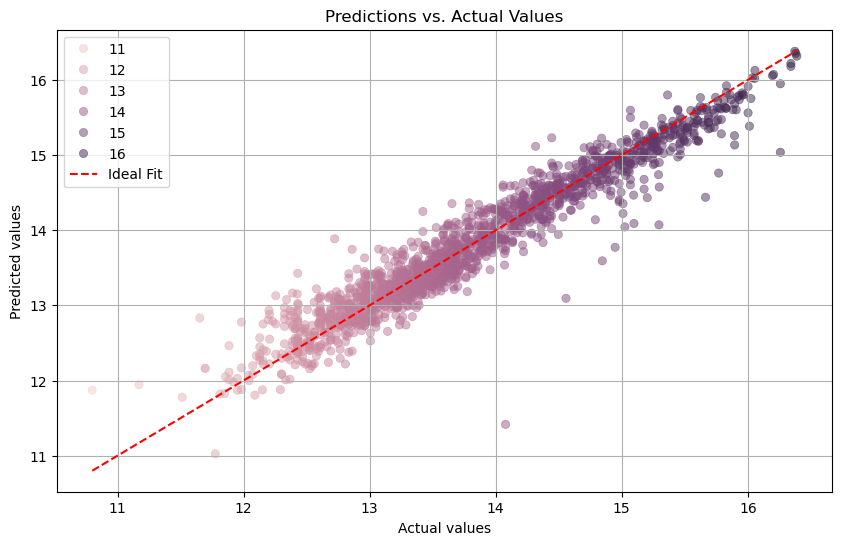

 === MODEL 1 === 
 mse: 0.06853423458357541
 rmse: 0.2617904402066191
 mae: 0.1865309579999347
 mae (price): 279092.4251137264
 r2: 0.925195354913482
Plotting Predicted vs Actual (multi-feature input)


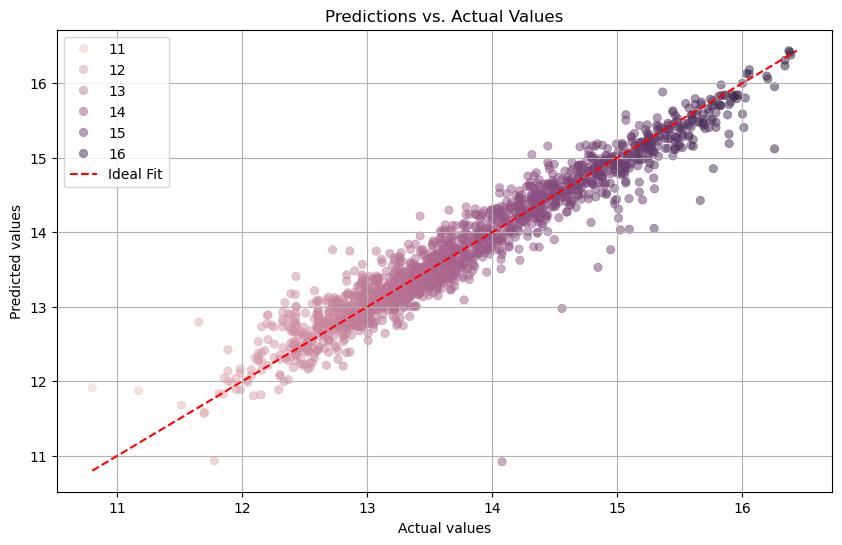

 === MODEL 2 === 
 mse: 0.06676833123555012
 rmse: 0.2583956873393016
 mae: 0.1809734079127148
 mae (price): 270902.83440365305
 r2: 0.9271228262569466
Plotting Predicted vs Actual (multi-feature input)


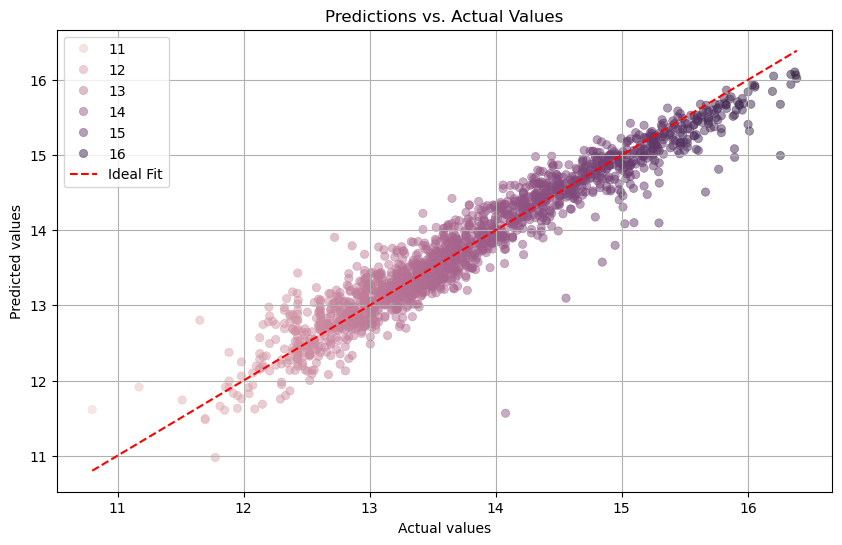

 === MODEL 3 === 
 mse: 0.07009535006416452
 rmse: 0.26475526446921605
 mae: 0.1925082700341359
 mae (price): 300991.5511051446
 r2: 0.9234914081170509
Plotting Predicted vs Actual (multi-feature input)


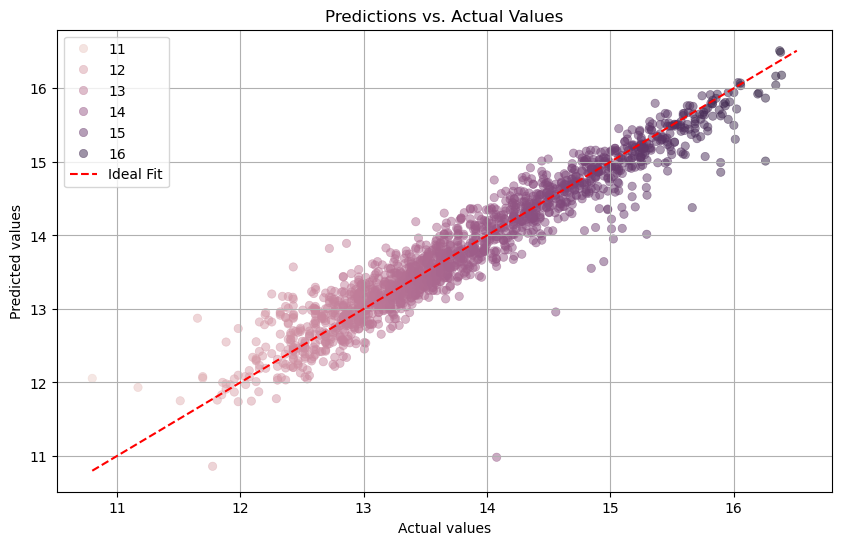

 === MODEL 4 === 
 mse: 0.07881452405186117
 rmse: 0.2807392456566434
 mae: 0.19955914241642167
 mae (price): 292150.8746323655
 r2: 0.9139744897541288


In [49]:
from Utils.visualization import *

SAVING_MODEL_PATH = 'ModelSave/linear_regression_model_'
SAVING_SCALER_PATH = 'ModelSave/scaler_'

df = pd.read_csv("Data/train.csv")
processor = VehicleDataPreprocessor()
df = processor.preprocess(df, train=True, norm=False)

y = df["Log_Price"]
X = df.drop("Log_Price", axis=1)

X = FeatureSelector._non_linearize_features(X)

for i in range(1, 5):
    feats, X_train = FeatureSelector.get_df(X, model_id=i, get_Log_Price=False)

    scaler_path = f"{SAVING_SCALER_PATH}{i}" + '.pkl'
    model_path = SAVING_MODEL_PATH + str(i) + '.pkl'

    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)

    X_train = scaler.transform(X_train)

    with open(model_path, 'rb') as f:
        model = pickle.load(f)

    y_pred = model.predict(X_train)
    results = model._evaluate(y, y_pred)

    visualize_results(X_train, y, y_pred)
    
    print(f" === MODEL {i} === ")
    for metric, value in results.items():
        print(f" {metric}: {value}")

## Đánh giá trên tập kiểm thử

Plotting Predicted vs Actual (multi-feature input)


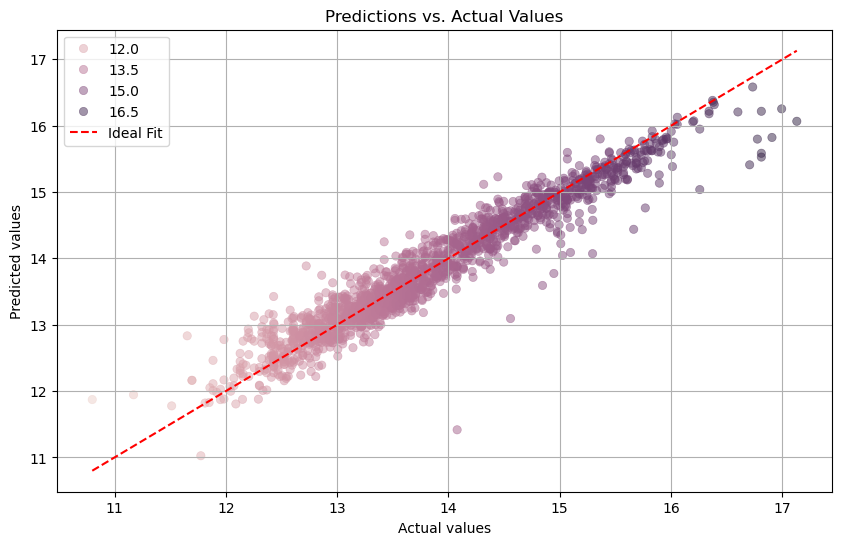

 === MODEL 1 === 
 mse: 0.07368970562522664
 rmse: 0.2714584786394167
 mae: 0.19074852046236287
 mae (price): 347616.8417808784
 r2: 0.9237552117560586
Plotting Predicted vs Actual (multi-feature input)


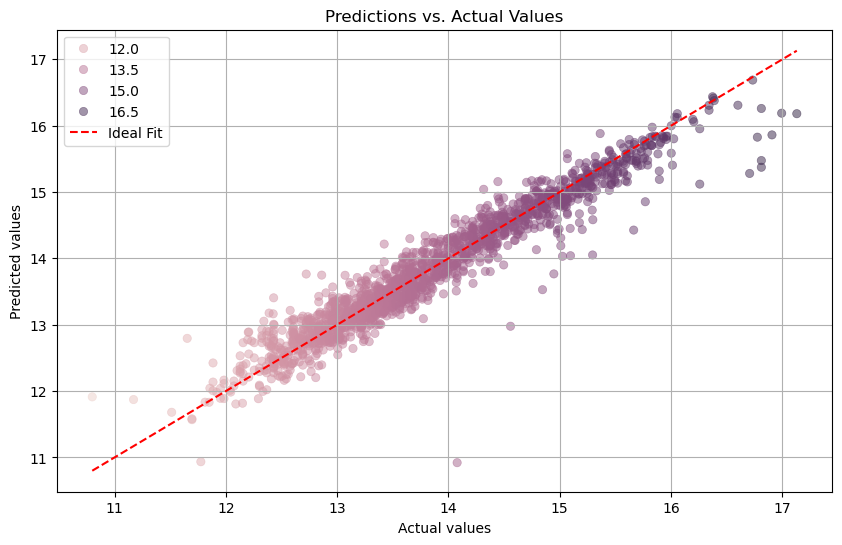

 === MODEL 2 === 
 mse: 0.0723266135311711
 rmse: 0.26893607703536376
 mae: 0.18524131806734861
 mae (price): 338054.2727627802
 r2: 0.9251655670721297
Plotting Predicted vs Actual (multi-feature input)


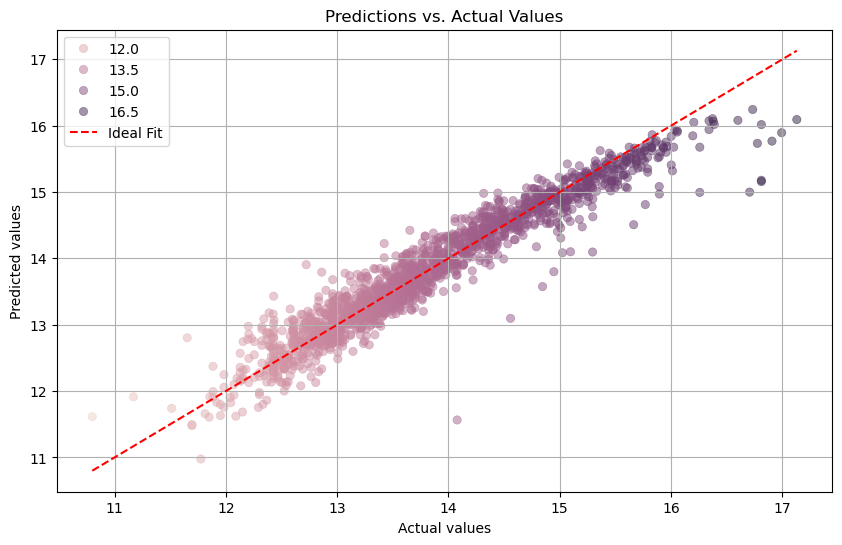

 === MODEL 3 === 
 mse: 0.07824955668148642
 rmse: 0.27973122221426483
 mae: 0.19808989084572845
 mae (price): 379868.15315008064
 r2: 0.9190372545426507
Plotting Predicted vs Actual (multi-feature input)


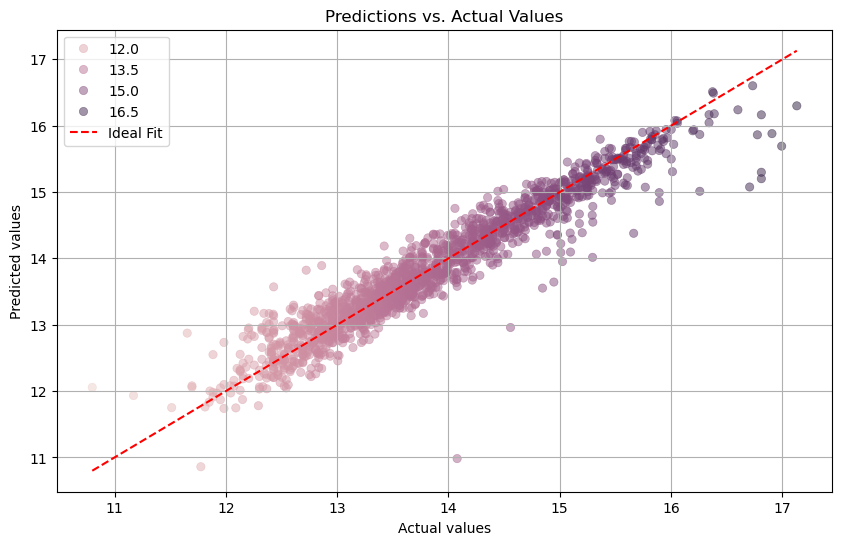

 === MODEL 4 === 
 mse: 0.0858530603123472
 rmse: 0.29300692877873585
 mae: 0.2043990968279019
 mae (price): 364129.34377898875
 r2: 0.9111701105592642


In [ ]:
import numpy as np
import pandas as pd
import pickle
from PreProcessing.FeatureSelector import FeatureSelector
from PreProcessing.VehicleDataPreprocessor import VehicleDataPreprocessor
from LinearModel.StandardScaler import StandardScaler
from Utils.visualization import *

# ============== Khúc này thầy chỉnh <Test> thành tên của file csv thầy muốn test nha ===============
TEST_PATH = '<Test>.csv'

SAVING_MODEL_PATH = 'ModelSave/linear_regression_model_'
SAVING_SCALER_PATH = 'ModelSave/scaler_'

df = pd.read_csv(TEST_PATH)
processor = VehicleDataPreprocessor()
df = processor.preprocess(df, train=False, norm=False)

y = df["Log_Price"]
X = df.drop("Log_Price", axis=1)

X = FeatureSelector._non_linearize_features(X)

for i in range(1, 5):
    feats, X_train = FeatureSelector.get_df(X, model_id=i, get_Log_Price=False)

    scaler_path = f"{SAVING_SCALER_PATH}{i}" + '.pkl'
    model_path = SAVING_MODEL_PATH + str(i) + '.pkl'

    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)

    X_train = scaler.transform(X_train)

    with open(model_path, 'rb') as f:
        model = pickle.load(f)

    y_pred = model.predict(X_train)
    results = model._evaluate(y, y_pred)

    visualize_results(X_train, y, y_pred)

    print(f" === MODEL {i} === ")
    for metric, value in results.items():
        print(f" {metric}: {value}")